Pattern -> Descriptors -> Embeddings -> Coordinates (by patt index)

  -->  MIDI Drum Assignment -> Notes In Channels -> Flattening Type Results (by patt index) ==> for all flattening types.
  
---
Build and test NN for each (flat, coord) combo & report MAE results.

In [3]:
## Imports ##
import os
import numpy as np
import sys
import random
import importlib
import pickle



In [1]:
## TODO: double check these need to be imported in this file
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as tdata
import torch.backends.mps
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
## File Locations (GitHub repo dir) ##
dir=os.getcwd()
os.listdir(dir)

import descriptors as desc
import functions as func
import flatten as flat
import neuralnetwork

/Users/peterclark/opt/anaconda3/envs/main/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Using cpu device


In [ ]:
## File Locations (Google Drive) ##
#drive.mount('/content/drive/MyDrive/Tapping_Force_Experiment_Data')

'''
Mounting my drive doesn't work by code, but does by side panel.
We will need to figure this

dir = os.chdir('/content/drive/MyDrive/Tapping_Force_Experiment_Data')
os.listdir(dir)
import descriptors as desc
import functions as func
'''

"\nMounting my drive doesn't work by code, but does by side panel.\nWe will need to figure this\n\ndir = os.chdir('/content/drive/MyDrive/Tapping_Force_Experiment_Data')\nos.listdir(dir)\nimport descriptors as desc\nimport functions as func\n"

In [5]:
## Patterns ##
all_pattlists, all_names = func.rootfolder2pattlists("midi/","allinstruments")


In [6]:
## Descriptors & Embedding Coordinates ~23s ##
d = desc.lopl2descriptors(all_pattlists)

mds_pos = func.d_mtx_2_mds(d)

In [7]:
## Convert Patterns (Full MIDI --> (8?) 3-Channel) ##
patterns = [] # 3 channel patterns
importlib.reload(flat)

for patt in all_pattlists:
    p = flat.get_LMH(patt)
    patterns.append(p)
print(patterns[230])

savedir = os.getcwd()+"/data/"
file = open(savedir+"patterns.pkl", 'wb')
pickle.dump(patterns, file, -1)
file.close()

[[1, 2, 3], [2, 3], [2, 3], [2, 3], [1, 2, 2, 3], [3], [2, 2, 3], [2, 3], [1, 3], [2, 3], [2, 3], [2, 3], [1, 2, 2, 3], [2, 3], [2, 3], [3]]


### Analytical Flattening Types:

Types: | Combo: | FuncRef: | Index: |
|---|:---:|---|---:|
**Onset Density** | (only) | [0,0,0] | 0 |
&emsp; &emsp; +| Metrical Strength  | [0,1,0] | 1 |
&emsp; &emsp; +| Syncopation  | [0,0,1] | 2 |
&emsp; &emsp; +| Metrical Strength <br>& Syncopation  | [0,1,1] | 3 |
--- | --- | --- | ---
**Frequency Weighted <br>Onset Density** | (only) | [1,0,0] | 4 |
&emsp; &emsp; +| Metrical Strength  | [1,1,0] | 5 |
&emsp; &emsp; +| Syncopation  | [1,0,1] | 6 |
&emsp; &emsp; +| Metrical Strength <br>& Syncopation  | [1,1,1] | 7 |
--- | --- | --- | ---
**Pattern Relative <br>Onset Density** | (only) | [2,0,0] | 8 |
&emsp; &emsp; +| Metrical Strength  | [2,1,0] | 9 |
&emsp; &emsp; +| Syncopation  | [2,0,1] | 10 |
&emsp; &emsp; +| Metrical Strength <br>& Syncopation  | [2,1,1] | 11 |
--- | --- | --- | ---
**Note Presence** | (only/mono) | [3,0,0] | 12 |
&emsp; &emsp; +| Metrical Strength  | [3,1,0] | 13 |
&emsp; &emsp; +| Syncopation  | [3,0,1] | 14 |
&emsp; &emsp; +| Metrical Strength <br>& Syncopation  | [3,1,1] | 15 |
&emsp; &emsp; +| Polyphonic Syncopation  | [3,0,2] | 16 |




In [8]:
# density types
onset_density=0
freq_weighted_onset_density=1
relative_onset_density=2
note_presence=3
# meter
no_meter=0
meter=1
# sync
no_sync=0
sync=1
polysync=2

In [9]:
importlib.reload(flat)
## Convert 3-channel to all 17 flat types. ##

n_patterns = len(patterns)
types = 17
flat_names = ['OnsetDen', 'OnsetDen_Meter', 'OnsetDen_Sync','OnsetDen_Sync_Meter',
              'FreqWeightOnsetDen', 'FreqWeightOnsetDen_Meter', 'FreqWeightOnsetDen_Sync','FreqWeightOnsetDen_Sync_Meter',
              'RelOnsetDen', 'RelOnsetDen_Meter', 'RelOnsetDen_Sync','RelOnsetDen_Sync_Meter',
              'Mono', 'Mono_Meter', 'Mono_Sync','Mono_Sync_Meter', 'Mono_PolySync']
len_patt = 16

# test
# patterns=patterns[13:20]

flatterns = np.array([[[0.0 for z in range(len_patt)] for y in range(types)] for x in range(n_patterns)], dtype=float) 
for p in range(len(patterns)):
    pattern = patterns[p]
# Onset Density
    flatterns[p][0] = flat.flat(pattern, onset_density, no_meter, no_sync)
    flatterns[p][1] = flat.flat(pattern, onset_density, meter, no_sync)
    flatterns[p][2] = flat.flat(pattern, onset_density, no_meter, sync)
    flatterns[p][3] = flat.flat(pattern, onset_density, meter, sync)
# Frequency Weighted Onset Density
    flatterns[p][4] = flat.flat(pattern, freq_weighted_onset_density, no_meter, no_sync)
    flatterns[p][5] = flat.flat(pattern, freq_weighted_onset_density, meter, no_sync)
    flatterns[p][6] = flat.flat(pattern, freq_weighted_onset_density, no_meter, sync)
    flatterns[p][7] = flat.flat(pattern, freq_weighted_onset_density, meter, sync)
# Pattern Relatiive Onset Density
    flatterns[p][8] = flat.flat(pattern, relative_onset_density, no_meter, no_sync)
    flatterns[p][9] = flat.flat(pattern, relative_onset_density, meter, no_sync)
    flatterns[p][10] = flat.flat(pattern, relative_onset_density, no_meter, sync)
    flatterns[p][11] = flat.flat(pattern, relative_onset_density, meter, sync)
# Note Presence
    flatterns[p][12] = flat.flat(pattern, note_presence, no_meter, no_sync)
    flatterns[p][13] = flat.flat(pattern, note_presence, meter, no_sync)
    flatterns[p][14] = flat.flat(pattern, note_presence, no_meter, sync)
    flatterns[p][15] = flat.flat(pattern, note_presence, meter, sync)
    flatterns[p][16] = flat.flat(pattern, note_presence, meter, polysync)
    if p %100==0:
        print(f"[x] - {p}/{len(patterns)}")
print(f"[x] - {p+1}/{len(patterns)}")

savedir = os.getcwd()+"/data/"
file = open(savedir+"flattened_patterns.pkl", 'wb')
pickle.dump(flatterns, file, -1)
file.close()

[x] - 0/1387
[x] - 100/1387
[x] - 200/1387
[x] - 300/1387
[x] - 400/1387
[x] - 500/1387
[x] - 600/1387
[x] - 700/1387
[x] - 800/1387
[x] - 900/1387
[x] - 1000/1387
[x] - 1100/1387
[x] - 1200/1387
[x] - 1300/1387
[x] - 1387/1387


In [10]:
''' CHANGE THIS TO DESIRED FLATTENING TYPE'''
flat_type = 17

""" print(flatterns.shape)
flattern = flatterns[:,flat_type,:]
print(flat_names[flat_type])
print(np.round(flattern[13:19],4)) """

for i in range(flat_type):
    print(flatterns.shape)
    flattern = flatterns[:,i,:]
    print(flat_names[i])
    print(flattern[824]) # example

(1387, 17, 16)
OnsetDen
[0.6 0.4 0.4 0.2 1.  0.4 0.4 0.4 0.6 0.2 0.4 0.4 1.  0.2 0.2 0.2]
(1387, 17, 16)
OnsetDen_Meter
[0.975  0.15   0.275  0.075  1.     0.15   0.275  0.15   0.7875 0.075
 0.275  0.15   1.     0.075  0.1375 0.075 ]
(1387, 17, 16)
OnsetDen_Sync
[0.6 0.4 0.4 0.2 1.  0.4 0.4 0.4 0.6 0.2 0.4 0.4 1.  0.2 0.2 0.2]
(1387, 17, 16)
OnsetDen_Sync_Meter
[0.975  0.15   0.275  0.075  1.     0.15   0.275  0.15   0.7875 0.075
 0.275  0.15   1.     0.075  0.1375 0.075 ]
(1387, 17, 16)
FreqWeightOnsetDen
[0.66666667 0.33333333 0.33333333 0.11111111 1.         0.33333333
 0.33333333 0.33333333 0.66666667 0.11111111 0.33333333 0.33333333
 1.         0.11111111 0.11111111 0.11111111]
(1387, 17, 16)
FreqWeightOnsetDen_Meter
[1.         0.1        0.2        0.03333333 0.9        0.1
 0.2        0.1        0.8        0.03333333 0.2        0.1
 0.9        0.03333333 0.06666667 0.03333333]
(1387, 17, 16)
FreqWeightOnsetDen_Sync
[0.66666667 0.33333333 0.33333333 0.11111111 1.         0.33333

In [11]:
## Load? ##
_load = False
model_dir=''
importlib.reload(neuralnetwork)

## Define model structure ##
model_layers=4
len_pattern=16 # input layer
firstlayer=32
secondlayer=32
thirdlayer=16
fourthlayer=16
coords=2 # output layer

## Build / Load model ##
if _load:
    model=neuralnetwork.load_model(model_dir)
else:
    model = neuralnetwork.build_model(len_pattern=16,firstlayer=32,secondlayer=32,thirdlayer=16,fourthlayer=16,coords=2)

## Select model hyperparameters ##
learning_rate = 0.002
batch_size = 32
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 300

train_loss = 0.0
test_loss = 0.0

Using cpu device


### Analytical Flattening Types:

Types: | Combo: | FuncRef: | Index: |
|---|:---:|---|---:|
**Onset Density** | (only) | [0,0,0] | 0 |
&emsp; &emsp; +| Metrical Strength  | [0,1,0] | 1 |
&emsp; &emsp; +| Syncopation  | [0,0,1] | 2 |
&emsp; &emsp; +| Metrical Strength <br>& Syncopation  | [0,1,1] | 3 |
--- | --- | --- | ---
**Frequency Weighted <br>Onset Density** | (only) | [1,0,0] | 4 |
&emsp; &emsp; +| Metrical Strength  | [1,1,0] | 5 |
&emsp; &emsp; +| Syncopation  | [1,0,1] | 6 |
&emsp; &emsp; +| Metrical Strength <br>& Syncopation  | [1,1,1] | 7 |
--- | --- | --- | ---
**Pattern Relative <br>Onset Density** | (only) | [2,0,0] | 8 |
&emsp; &emsp; +| Metrical Strength  | [2,1,0] | 9 |
&emsp; &emsp; +| Syncopation  | [2,0,1] | 10 |
&emsp; &emsp; +| Metrical Strength <br>& Syncopation  | [2,1,1] | 11 |
--- | --- | --- | ---
**Note Presence** | (only/mono) | [3,0,0] | 12 |
&emsp; &emsp; +| Metrical Strength  | [3,1,0] | 13 |
&emsp; &emsp; +| Syncopation  | [3,0,1] | 14 |
&emsp; &emsp; +| Metrical Strength <br>& Syncopation  | [3,1,1] | 15 |
&emsp; &emsp; +| Polyphonic Syncopation  | [3,0,2] | 16 |



In [12]:
### SELECT WHICH ALG ###
flattern_num = 4

input_data = np.asarray(flatterns[:,flattern_num,:],dtype=np.float32)
target_data = np.asarray(mds_pos,dtype=np.float32)


# make semi continuous
_semicontinuous = False
if _semicontinuous:
    p_means = np.mean(input_data, axis=1, keepdims=True)
    input_data[input_data<p_means] = 0.0

# make discrete
_discrete = False
if _discrete:
    p_means = np.mean(input_data, axis=1, keepdims=True)
    input_data[input_data>=p_means] = 1
    input_data[input_data<p_means] = 0

print(input_data[220:230])

[[0.75  0.375 0.375 0.375 1.    0.125 0.625 0.375 0.5   0.375 0.375 0.375
  1.    0.375 0.375 0.125]
 [0.75  0.375 0.625 0.375 1.    0.125 0.625 0.375 0.75  0.375 0.625 0.375
  1.    0.375 0.625 0.125]
 [0.75  0.375 0.375 0.375 1.    0.125 0.625 0.375 0.5   0.375 0.375 0.375
  1.    0.375 0.375 0.125]
 [0.75  0.375 0.625 0.375 1.    0.125 0.625 0.375 0.75  0.375 0.625 0.375
  1.    0.375 0.625 0.125]
 [0.75  0.375 0.375 0.375 1.    0.125 0.625 0.375 0.5   0.375 0.375 0.375
  1.    0.375 0.375 0.125]
 [0.75  0.375 0.625 0.375 1.    0.125 0.625 0.375 0.75  0.375 0.625 0.375
  1.    0.375 0.625 0.125]
 [0.75  0.375 0.375 0.375 1.    0.125 0.625 0.375 0.5   0.375 0.375 0.375
  1.    0.375 0.375 0.125]
 [0.75  0.375 0.625 0.375 1.    0.125 0.625 0.375 0.75  0.375 0.625 0.375
  1.    0.375 0.625 0.125]
 [0.75  0.375 0.375 0.375 1.    0.125 0.625 0.375 0.5   0.375 0.375 0.375
  1.    0.375 0.375 0.125]
 [0.75  0.375 0.625 0.375 1.    0.125 0.625 0.375 0.75  0.375 0.625 0.375
  1.    0.375 0.6

In [13]:
## 10 fold cross evaluation splits ##
training_DL_list = []
validation_DL_list = []

seed=np.random.randint(0,1000) ## for traintest splits. 
train, test, train_coords, test_coords = train_test_split(input_data, target_data, test_size=0.2, random_state=seed)
test_dataset = neuralnetwork.CustomDataset(test, test_coords)
test_dataloader = tdata.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# make train and validation splits on training data
folds=10
kfold = KFold(n_splits=folds, shuffle=True) 

for train_idx, validation_idx in kfold.split(train):
    
    train_fold, validation_fold = input_data[train_idx], input_data[validation_idx]
    target_fold, target_val_fold = target_data[train_idx], target_data[validation_idx]

    train_dataset = neuralnetwork.CustomDataset(train_fold, target_fold)
    validation_dataset = neuralnetwork.CustomDataset(validation_fold, target_val_fold)

    train_dataloader = tdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_dataloader = tdata.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    training_DL_list.append(train_dataloader)
    validation_DL_list.append(validation_dataloader)

In [14]:
## Train a model on 10-folds for one flattening algorithm ##
## This process can take around 35-40sec ##
importlib.reload(neuralnetwork)
accuracy=[[0.0,0.0] for n in range(len(training_DL_list))] # num splits
for split in range(len(training_DL_list)):
    dataloader = training_DL_list[split]
    val_dataloader = validation_DL_list[split]

    neuralnetwork.train_loop(model, dataloader, epochs, criterion, optimizer)
    all_acc = []
    all_acc, accuracy[split][1], _ = neuralnetwork.test_loop(model, val_dataloader, criterion)
    accuracy[split][0] = np.average(all_acc)
    print(f"Fold:{split} Avg:{accuracy[split][0]:.4f}({np.std(all_acc):.4f}) FinalTestLoss:{accuracy[split][1]:.3f}")
print(f"{np.average(accuracy[split][0])}")


Using cpu device
Fold:0 Avg:0.0302(0.0472) FinalTestLoss:0.001
Fold:1 Avg:0.0365(0.0823) FinalTestLoss:0.004
Fold:2 Avg:0.0335(0.0948) FinalTestLoss:0.004
Fold:3 Avg:0.0263(0.0282) FinalTestLoss:0.001
Fold:4 Avg:0.0142(0.0630) FinalTestLoss:0.002
Fold:5 Avg:0.0200(0.0735) FinalTestLoss:0.003
Fold:6 Avg:0.0308(0.1241) FinalTestLoss:0.007
Fold:7 Avg:0.0276(0.0612) FinalTestLoss:0.002
Fold:8 Avg:0.0088(0.0093) FinalTestLoss:0.000
Fold:9 Avg:0.0077(0.0099) FinalTestLoss:0.000
0.007669155565752681


In [15]:
## Evaluate Model ##
mean_abs_errors, _, __ = neuralnetwork.test_loop(model, test_dataloader, criterion)
mean_abs_error = np.average(mean_abs_errors)
mean_CV = round(np.std(mean_abs_errors)/mean_abs_error,4)
print(f"Algorithm: {flat_names[flattern_num]} --> MAE: {mean_abs_error:.4f} [std:{np.std(mean_abs_errors)}] ***** Test Dataset Only *****")

whole_dataset = neuralnetwork.CustomDataset(input_data, target_data)
whole_dataloader = tdata.DataLoader(whole_dataset, batch_size=batch_size, shuffle=False)
mean_abs_errors, _ , pred_coords= neuralnetwork.test_loop(model, whole_dataloader, criterion)
mean_abs_error = np.average(mean_abs_errors)
mean_CV = round(np.std(mean_abs_errors)/mean_abs_error,4)
print(f"Algorithm: {flat_names[flattern_num]} --> MAE: {mean_abs_error:.4f} [std:{np.std(mean_abs_errors)}] ***** Whole Dataset *****")

Algorithm: FreqWeightOnsetDen --> MAE: 0.0375 [std:0.0932834841554347] ***** Test Dataset Only *****
Algorithm: FreqWeightOnsetDen --> MAE: 0.0353 [std:0.0864968737692899] ***** Whole Dataset *****


In [16]:
importlib.reload(neuralnetwork)
pred_coords, distance = neuralnetwork.get_predicted_coords(input_data,target_data,model)
pred_coords=np.array(pred_coords, dtype=float)

Using cpu device


1033 - 354 0.7447728911319395


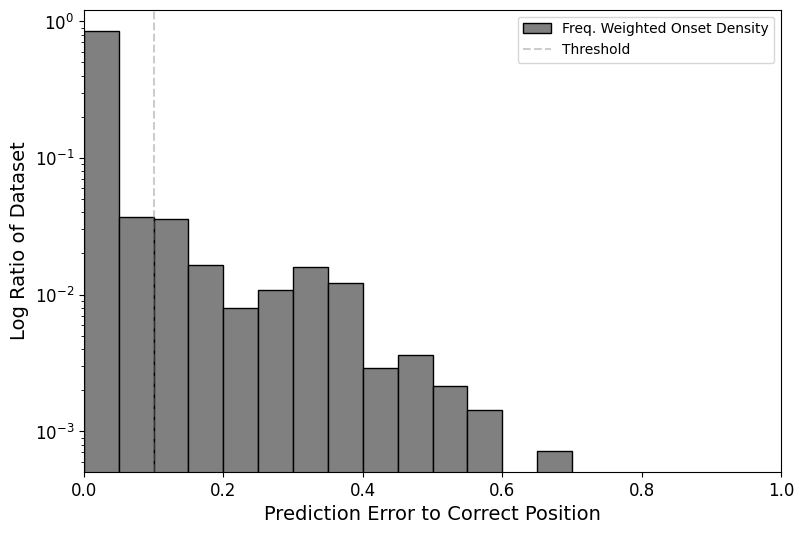

In [43]:
distance = np.array(distance)
print(f"{len(distance[distance<=0.01])} - {len(distance[distance>0.01])} {(len(distance[distance<=0.01]))/(len(distance[distance<=0.01])+len(distance[distance>0.01]))}")

# Parameters
bins = 20
bar_width = 1 / bins  # Adjust bar width to ensure the right number of bins

# Create an array to store counts for each bin
dist_bar = np.array([0.0 for x in range(bins)], dtype=float)

# Calculate the number of entries in each bin and normalize by the dataset size
for x in range(bins):
    dist_bar[x] += len(distance[distance <= (x+1)*bar_width]) - len(distance[distance <= x*bar_width])

# Create the figure and axes
fig, ax = plt.subplots(figsize=(9, 6))

# Plot the bar chart with the correct normalization to the total dataset size
b = ax.bar(np.arange(bins) * bar_width + bar_width / 2, dist_bar / len(distance), 
           color="grey", edgecolor="black", width=bar_width)

# Set the x-limits and labels
ax.set_xlim([0, 1])
ax.tick_params(labelsize=12)
ax.set_xlabel("Prediction Error to Correct Position", fontsize=14)
ax.set_ylabel("Log Ratio of Dataset", fontsize=14)
c=ax.axvline(x=0.1, color="grey", alpha=0.4, linestyle="--")
ax.set_yscale('log')
# Add legend
ax.legend([b,c], ['Freq. Weighted Onset Density', 'Threshold'])

# Show the plot
plt.show()

In [ ]:
for x in range(len(distance)):
    if distance[x]>0.1:
        print(f"err={distance[x]:.3f} {all_names[x]}")

err=0.343 chicago_jackyourbody_117
err=0.369 chicago_jackyourbody_118
err=0.330 chicago_jackyourbody_119
err=0.370 chicago_jackyourbody_120
err=0.483 chicago_jackyourbody_159
err=0.435 chicago_jackyourbody_161
err=0.308 chicago_lovecantturnaround_74
err=0.314 chicago_lovecantturnaround_76
err=0.191 chicago_youusedtoholdme_91
err=0.191 chicago_youusedtoholdme_93
err=0.191 chicago_youusedtoholdme_95
err=0.191 chicago_youusedtoholdme_97
err=0.191 chicago_youusedtoholdme_99
err=0.191 chicago_youusedtoholdme_101
err=0.191 chicago_youusedtoholdme_103
err=0.191 chicago_youusedtoholdme_105
err=0.191 chicago_youusedtoholdme_107
err=0.326 chicago_youusedtoholdme_156
err=0.375 chicago_youusedtoholdme_157
err=0.326 chicago_youusedtoholdme_158
err=0.375 chicago_youusedtoholdme_159
err=0.326 chicago_youusedtoholdme_160
err=0.375 chicago_youusedtoholdme_161
err=0.326 chicago_youusedtoholdme_162
err=0.375 chicago_youusedtoholdme_163
err=0.302 chicago_youusedtoholdme_164
err=0.327 chicago_youusedtohold

Using cpu device


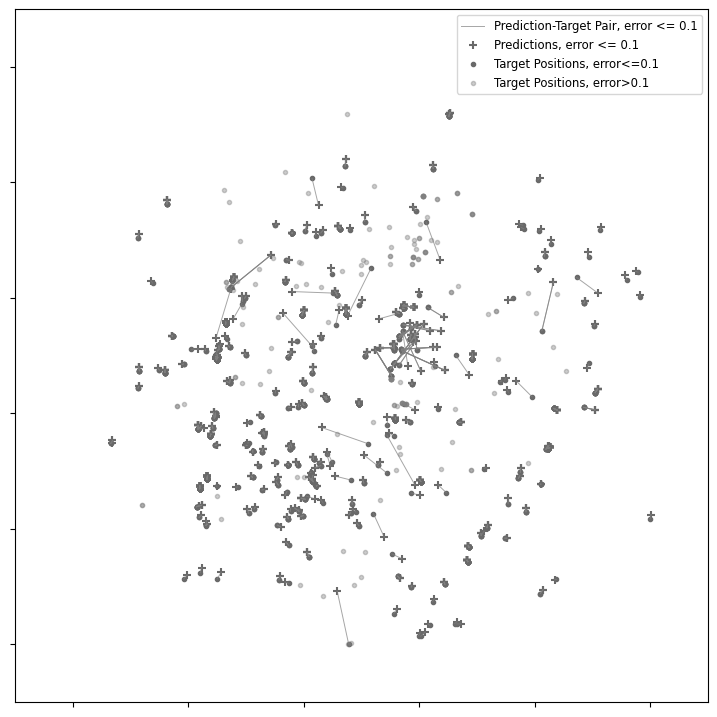

In [ ]:
## Plot NN results by distance ##
importlib.reload(neuralnetwork)
neuralnetwork.plot_points_with_lines(pred_coords, target_data)

The code below will build models for all flattening algorithms, but it will take time to complete. 

In [ ]:
## For all Flat: NN build + (train + test)-10fold ## WARNING: LONGTIME!
# TODO
importlib.reload(neuralnetwork)

train_scores = []
test_scores = []

for flat in range(len(flat_names)):
    print(f"Moving on to flat-type: {flat_names[flat]}" )
    ## PREPARE ----------------------------------------
    model = neuralnetwork.build_model(len_pattern=16,firstlayer=32,secondlayer=32,thirdlayer=16,fourthlayer=16,coords=2)
    ## Select model hyperparameters ##
    learning_rate = 0.0015
    batch_size = 32
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    epochs = 300

    input_data = np.asarray(flatterns[:,flat,:],dtype=np.float32)
    target_data = np.asarray(mds_pos,dtype=np.float32)

    # make semi continuous
    _semicontinuous = False
    if _semicontinuous:
        p_means = np.mean(input_data, axis=1, keepdims=True)
        input_data[input_data<p_means] = 0.0

    # make discrete
    _discrete = False
    if _discrete:
        p_means = np.mean(input_data, axis=1, keepdims=True)
        input_data[input_data>=p_means] = 1.0
        input_data[input_data<p_means] = 0.0

    ## 10 fold cross evaluation splits ##
    training_DL_list = []
    validation_DL_list = []

    seed=np.random.randint(0,1000) ## for traintest splits. 
    train, test, train_coords, test_coords = train_test_split(input_data, target_data, test_size=0.2, random_state=seed)
    test_dataset = neuralnetwork.CustomDataset(test, test_coords)
    test_dataloader = tdata.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # make train and validation splits on training data
    folds=5
    kfold = KFold(n_splits=folds, shuffle=True) 

    for train_idx, validation_idx in kfold.split(train):
        
        train_fold, validation_fold = input_data[train_idx], input_data[validation_idx]
        target_fold, target_val_fold = target_data[train_idx], target_data[validation_idx]

        train_dataset = neuralnetwork.CustomDataset(train_fold, target_fold)
        validation_dataset = neuralnetwork.CustomDataset(validation_fold, target_val_fold)

        train_dataloader = tdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        validation_dataloader = tdata.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

        training_DL_list.append(train_dataloader)
        validation_DL_list.append(validation_dataloader)

    accuracy=[[0.0,0.0] for n in range(len(training_DL_list))] # num splits
    for split in range(len(training_DL_list)):
        dataloader = training_DL_list[split]
        val_dataloader = validation_DL_list[split]

        neuralnetwork.train_loop(model, dataloader, epochs, criterion, optimizer)
        all_acc = []
        all_acc, accuracy[split][1] = neuralnetwork.test_loop(model, val_dataloader, criterion)
        accuracy[split][0] = np.average(all_acc)
        print(f"Fold:{split} Avg:{accuracy[split][0]:.4f} FinalTestLoss:{accuracy[split][1]:.3f}")
        train_scores.append(all_acc)

    ## Evaluate Model ##
    mean_abs_errors, _, pred_coords = neuralnetwork.test_loop(model, test_dataloader, criterion)
    mean_abs_error = np.average(mean_abs_errors)
    mean_CV = round(np.std(mean_abs_errors)/mean_abs_error,4)
    print(f"Algorithm: {flat_names[flat]} --> MAE: {mean_abs_error:.4f} [std:{np.std(mean_abs_errors)}] ***** Test Dataset Only *****")

    test_scores.append(mean_abs_errors)
    
    whole_dataset = neuralnetwork.CustomDataset(input_data, target_data)
    whole_dataloader = tdata.DataLoader(whole_dataset, batch_size=batch_size, shuffle=False)
    mean_abs_errors, _ = neuralnetwork.test_loop(model, whole_dataloader, criterion)
    mean_abs_error = np.average(mean_abs_errors)
    mean_CV = round(np.std(mean_abs_errors)/mean_abs_error,4)
    print(f"Algorithm: {flat_names[flat]} --> MAE: {mean_abs_error:.4f} [std:{np.std(mean_abs_errors)}] ***** Whole Dataset *****")
    


Using cpu device
Moving on to flat-type: OnsetDen
Fold:0 Avg:0.1628 FinalTestLoss:0.023
Fold:1 Avg:0.1425 FinalTestLoss:0.017
Fold:2 Avg:0.1496 FinalTestLoss:0.021
Fold:3 Avg:0.1552 FinalTestLoss:0.022
Fold:4 Avg:0.1324 FinalTestLoss:0.017
Algorithm: OnsetDen --> MAE: 0.1579 [std:0.13659816229333624] ***** Test Dataset Only *****
Algorithm: OnsetDen --> MAE: 0.1535 [std:0.13003744486214106] ***** Whole Dataset *****
Moving on to flat-type: OnsetDen_Meter
Fold:0 Avg:0.2162 FinalTestLoss:0.033
Fold:1 Avg:0.2169 FinalTestLoss:0.031
Fold:2 Avg:0.1996 FinalTestLoss:0.025
Fold:3 Avg:0.1987 FinalTestLoss:0.027
Fold:4 Avg:0.2128 FinalTestLoss:0.030
Algorithm: OnsetDen_Meter --> MAE: 0.2265 [std:0.1197344374683496] ***** Test Dataset Only *****
Algorithm: OnsetDen_Meter --> MAE: 0.2128 [std:0.1155751288122925] ***** Whole Dataset *****
Moving on to flat-type: OnsetDen_Sync
Fold:0 Avg:0.0636 FinalTestLoss:0.006
Fold:1 Avg:0.0580 FinalTestLoss:0.004
Fold:2 Avg:0.0538 FinalTestLoss:0.004
Fold:3 Av

In [ ]:
# some data rearranging
trn_scores = []
train_means = np.array([[0.0 for x in range(folds)] for y in range(len(flat_names))], dtype=float)
train_stds = np.array([[0.0 for x in range(folds)] for y in range(len(flat_names))], dtype=float)
for f in range(len(flat_names)):
    t_s = []
    for g in range(folds):
        t_s.append(train_scores[f*g+g])
        train_means[f][g]=np.mean(np.asarray(train_scores[f*g+g],dtype=float))
        train_stds[f][g]=np.std(np.asarray(train_scores[f*g+g],dtype=float))
    trn_scores.append(t_s)

for a in range(len(flat_names)):
    print(f"{flat_names[a]}")
    train_mean = np.mean(train_means[a])
    train_std = np.mean(train_stds[a])
    #print(f"TRAIN: {train_mean:.4f}, {train_std:.4f}")
    print(f"TEST: {np.mean(test_scores[a]):.4f}, ({np.std(test_scores[a]):.4f})")

OnsetDen
TEST: 0.1579, (0.1366)
OnsetDen_Meter
TEST: 0.2265, (0.1197)
OnsetDen_Sync
TEST: 0.0668, (0.0873)
OnsetDen_Sync_Meter
TEST: 0.1527, (0.1258)
FreqWeightOnsetDen
TEST: 0.1526, (0.1350)
FreqWeightOnsetDen_Meter
TEST: 0.2224, (0.1046)
FreqWeightOnsetDen_Sync
TEST: 0.1552, (0.1393)
FreqWeightOnsetDen_Sync_Meter
TEST: 0.2334, (0.1176)
RelOnsetDen
TEST: 0.1426, (0.1238)
RelOnsetDen_Meter
TEST: 0.1843, (0.1134)
RelOnsetDen_Sync
TEST: 0.1451, (0.1356)
RelOnsetDen_Sync_Meter
TEST: 0.1582, (0.1255)
Mono
TEST: 0.0976, (0.0980)
Mono_Meter
TEST: 0.2116, (0.1060)
Mono_Sync
TEST: 0.1041, (0.0981)
Mono_Sync_Meter
TEST: 0.2145, (0.1013)
Mono_PolySync
TEST: 0.0850, (0.1127)


### 300 0.0015 cont ###

OnsetDen
TEST: 0.0436, (0.0778)

OnsetDen_Meter
TEST: 0.0438, (0.0934)

OnsetDen_Sync
TEST: 0.0444, (0.0878)

OnsetDen_Sync_Meter
TEST: 0.0366, (0.0802)

FreqWeightOnsetDen
TEST: 0.0391, (0.0906)

FreqWeightOnsetDen_Meter
TEST: 0.0517, (0.0838)

FreqWeightOnsetDen_Sync
TEST: 0.0480, (0.0954)

FreqWeightOnsetDen_Sync_Meter
TEST: 0.0539, (0.0923)

RelOnsetDen
TEST: 0.0448, (0.0752)

RelOnsetDen_Meter
TEST: 0.0406, (0.0784)

RelOnsetDen_Sync
TEST: 0.0560, (0.1062)

RelOnsetDen_Sync_Meter
TEST: 0.0543, (0.1111)

Mono
TEST: 0.1042, (0.1010)

Mono_Meter
TEST: 0.1125, (0.1045)

Mono_Sync
TEST: 0.0971, (0.0937)

Mono_Sync_Meter
TEST: 0.0970, (0.0966)

Mono_PolySync
TEST: 0.0672, (0.1084)


### 300 0.0015 semi-cont ###

OnsetDen
TEST: 0.0832, (0.1357)

OnsetDen_Meter
TEST: 0.1085, (0.1317)

OnsetDen_Sync
TEST: 0.0526, (0.1068)

OnsetDen_Sync_Meter
TEST: 0.0777, (0.1180)

FreqWeightOnsetDen
TEST: 0.0585, (0.1041)

FreqWeightOnsetDen_Meter
TEST: 0.1656, (0.1219)

FreqWeightOnsetDen_Sync
TEST: 0.0639, (0.1156)

FreqWeightOnsetDen_Sync_Meter
TEST: 0.1360, (0.1623)

RelOnsetDen
TEST: 0.0808, (0.1217)

RelOnsetDen_Meter
TEST: 0.1211, (0.1304)

RelOnsetDen_Sync
TEST: 0.0739, (0.1390)

RelOnsetDen_Sync_Meter
TEST: 0.0714, (0.1393)

Mono
TEST: 0.1115, (0.1048)

Mono_Meter
TEST: 0.2247, (0.1064)

Mono_Sync
TEST: 0.1081, (0.1081)

Mono_Sync_Meter
TEST: 0.2142, (0.1151)

Mono_PolySync
TEST: 0.0749, (0.1132)

### 300 0.0015 discrete ###

OnsetDen
TEST: 0.1579, (0.1366)

OnsetDen_Meter
TEST: 0.2265, (0.1197)

OnsetDen_Sync
TEST: 0.0668, (0.0873)

OnsetDen_Sync_Meter
TEST: 0.1527, (0.1258)

FreqWeightOnsetDen
TEST: 0.1526, (0.1350)

FreqWeightOnsetDen_Meter
TEST: 0.2224, (0.1046)

FreqWeightOnsetDen_Sync
TEST: 0.1552, (0.1393)

FreqWeightOnsetDen_Sync_Meter
TEST: 0.2334, (0.1176)

RelOnsetDen
TEST: 0.1426, (0.1238)

RelOnsetDen_Meter
TEST: 0.1843, (0.1134)

RelOnsetDen_Sync
TEST: 0.1451, (0.1356)

RelOnsetDen_Sync_Meter
TEST: 0.1582, (0.1255)

Mono
TEST: 0.0976, (0.0980)

Mono_Meter
TEST: 0.2116, (0.1060)

Mono_Sync
TEST: 0.1041, (0.0981)

Mono_Sync_Meter
TEST: 0.2145, (0.1013)

Mono_PolySync
TEST: 0.0850, (0.1127)
